In [1]:
import warnings
warnings.simplefilter('ignore')
from neurocaps.extraction import TimeseriesExtractor
from neurocaps.analysis import CAP, merge_dicts

help(TimeseriesExtractor)
parcel_approach = {"Schaefer": {"n_rois": 100, "yeo_networks": 7, "resolution_mm": 2}}
#parcel_approach = {"AAL": {"version": "SPM12"}}

ncol = parcel_approach["Schaefer"]["n_rois"] if "Schaefer" in parcel_approach.keys() else 116
extractor = TimeseriesExtractor(parcel_approach=parcel_approach)

Help on class TimeseriesExtractor in module neurocaps.extraction.timeseriesextractor:

class TimeseriesExtractor(neurocaps._utils._timeseriesextractor_internals._timeseriesextractorgetter._TimeseriesExtractorGetter)
 |  TimeseriesExtractor(space: str = 'MNI152NLin2009cAsym', standardize: Union[bool, str] = 'zscore_sample', detrend: bool = True, low_pass: float = None, high_pass: float = None, parcel_approach: dict[dict] = {'Schaefer': {'n_rois': 400, 'yeo_networks': 7, 'resolution_mm': 1}}, use_confounds: bool = True, confound_names: list[str] = None, fwhm: float = None, fd_threshold: float = None, n_acompcor_separate: int = None, dummy_scans: int = None) -> None
 |  
 |  Method resolution order:
 |      TimeseriesExtractor
 |      neurocaps._utils._timeseriesextractor_internals._timeseriesextractorgetter._TimeseriesExtractorGetter
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, space: str = 'MNI152NLin2009cAsym', standardize: Union[bool, str] = 'zscore_s

In [2]:
help(extractor.get_bold)

Help on method get_bold in module neurocaps.extraction.timeseriesextractor:

get_bold(bids_dir: str, task: str, session: Union[int, str] = None, runs: list[int] = None, condition: str = None, tr: Union[int, float] = None, run_subjects: list[str] = None, exclude_subjects: list[str] = None, pipeline_name: str = None, n_cores: int = None, verbose: bool = True, flush_print: bool = False, exclude_niftis: list[str] = None) -> None method of neurocaps.extraction.timeseriesextractor.TimeseriesExtractor instance
    Get Bold Data
    
    Collects files needed to extract timeseries data from NIfTI files for BIDS-compliant datasets containing a derivatives folder. This function assumes that your BOLD data was preprocessed using a standard 
    preprocessing pipeline such as fMRIPrep.
    
    Parameters
    ----------
    bids_dir: str
        Path to a BIDS compliant directory. 
    task: str
        Name of task to process.
    session: int, default=None
        Session to extract timeseries f

In [3]:
# Attributes

print(dir(extractor))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_parcel_approach', '_setup_extraction', '_signal_clean_info', '_space', 'get_bold', 'n_cores', 'parcel_approach', 'signal_clean_info', 'space', 'subject_ids', 'subject_timeseries', 'task_info', 'timeseries_to_pickle', 'visualize_bold']


In [4]:
# Example structure of what extractor.get_bold() produces; the rows would be equal to the TRs and the columnn would be equal to the number of nodes. 
# So, all subjects would have the same column length which depends on the number inputted in n_nodes when initializing TimeseriesExtractor
# For visualization purposes, I will print out 5 by 5 arrays to show the general structure
import numpy as np

print({str(x) : {f"run-{y}": np.random.rand(5,5) for y in range(1,4)} for x in range(1,2)})

{'1': {'run-1': array([[0.71295767, 0.49602886, 0.56901453, 0.2766319 , 0.58303219],
       [0.72099456, 0.24479436, 0.39182149, 0.8628049 , 0.77672134],
       [0.79330263, 0.72660086, 0.14440625, 0.90149285, 0.18684966],
       [0.09779309, 0.22407674, 0.02606743, 0.32984897, 0.61088051],
       [0.53627347, 0.76091824, 0.64231388, 0.88289007, 0.73159585]]), 'run-2': array([[0.0219421 , 0.72835798, 0.12128769, 0.36449661, 0.06969298],
       [0.11850467, 0.69684961, 0.22422619, 0.19330869, 0.28214343],
       [0.74902445, 0.9634097 , 0.78864415, 0.98560929, 0.72158101],
       [0.15081968, 0.72121715, 0.31516109, 0.59655896, 0.55420569],
       [0.99866068, 0.2070624 , 0.572437  , 0.88133605, 0.68132026]]), 'run-3': array([[0.56703029, 0.92860642, 0.73381281, 0.68888891, 0.70608939],
       [0.44017187, 0.75464165, 0.60823556, 0.30188428, 0.47836408],
       [0.16384519, 0.56113535, 0.97276329, 0.16073545, 0.39920409],
       [0.45349822, 0.37129757, 0.73936205, 0.21129102, 0.8227923

In [5]:
# Generating a fuller subject timeseries for later cap analysis
extractor.subject_timeseries = {str(x) : {f"run-{y}": np.random.rand(50,ncol) for y in range(1,4)} for x in range(1,11)}

In [6]:
# Save randomly generated data in directory where jupyter notebook is running

import os, joblib

output_dir = os.path.dirname(__vsc_ipynb_file__)

extractor.timeseries_to_pickle(output_dir=output_dir, file_name="sample_for_neurocaps_demo_timeseries.pkl")

with open("sample_for_neurocaps_demo_timeseries.pkl", "rb") as f:
    subject_timeseries = joblib.load(f)


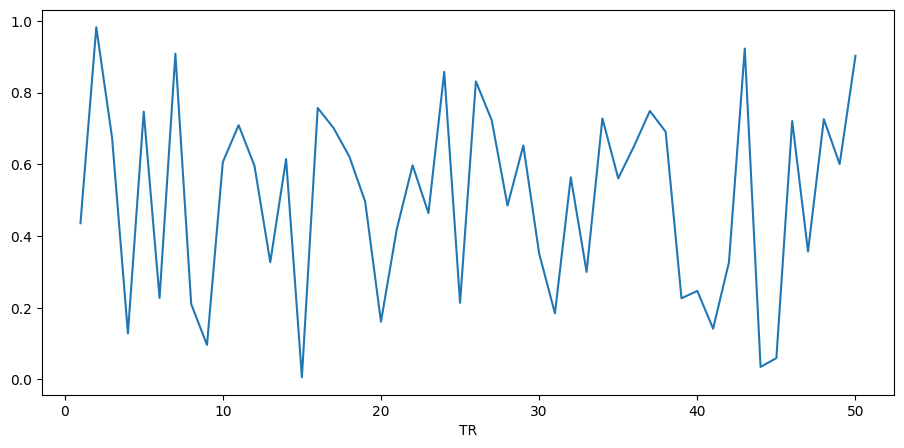

In [7]:
# Visualize Bold at node level

extractor.visualize_bold(subj_id="1",run=1, roi_indx=0)

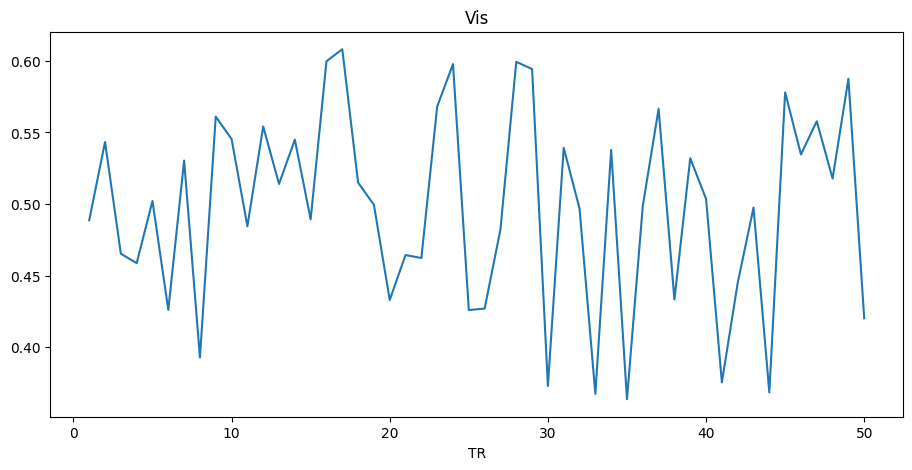

In [8]:
# Visualize Bold at network level
if ncol == 116:
    extractor.visualize_bold(subj_id="1",run=1, region="Cerebelum")
else:
    extractor.visualize_bold(subj_id="1",run=1, region="Vis")

In [9]:
# Performing Cap analysis with all subjects 

cap_analysis = CAP(parcel_approach=extractor.parcel_approach, n_clusters=3)

cap_analysis.get_caps(subject_timeseries=extractor.subject_timeseries)

In [10]:
subject_timeseries.keys()

dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

Optimal cluster size for A is 9.



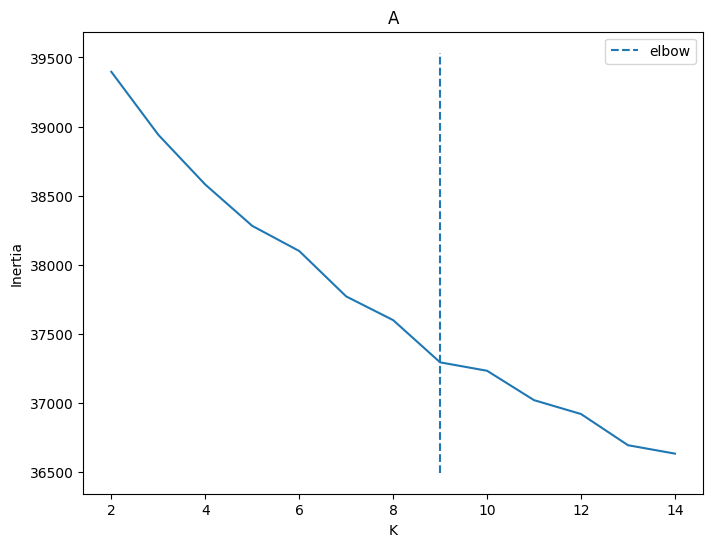

Optimal cluster size for B is 11.



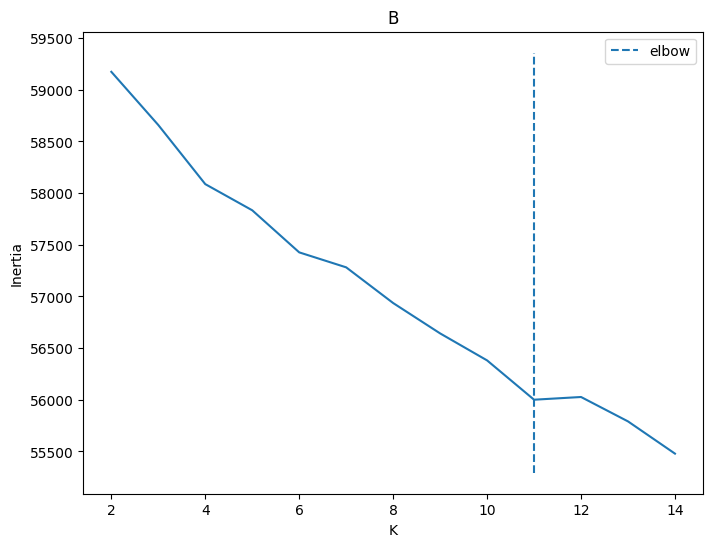

In [11]:
# Performing Cap analysis with groups, list of n_clusters, and elbow cluster selection method

cap_analysis = CAP(parcel_approach=extractor.parcel_approach, groups={"A": ["1","2","3","5"], "B": ["4","6","7","8","9","10"]}, n_clusters=list(range(2,15)), cluster_selection_method="elbow")

# When elbow method is specified, the associated plots will be shown, furthermore, the saved kmeans model for each group will automatically save to the optimal cluster size
#cap_analysis.get_caps(subject_timeseries="sample_for_neurocaps_demo_timeseries.pkl", runs=[1,2], show_figs=True, output_dir=output_dir)

cap_analysis.get_caps(subject_timeseries="sample_for_neurocaps_demo_timeseries.pkl", runs=[1,2], show_figs=True)

In [12]:
# Performing Cap analysis with groups, list of n_clusters, and silhouette cluster selection method

cap_analysis = CAP(parcel_approach=extractor.parcel_approach, groups={"A": ["1","2","3","5"], "B": ["4","6","7","8","9","10"]}, n_clusters=list(range(2,4)), cluster_selection_method="silhouette")

cap_analysis.get_caps(subject_timeseries="sample_for_neurocaps_demo_timeseries.pkl")

# kmeans model automatically save to the optimal size
cap_analysis.kmeans

Optimal cluster size for A is 2.
Optimal cluster size for B is 2.


{'A': KMeans(n_clusters=2), 'B': KMeans(n_clusters=2)}

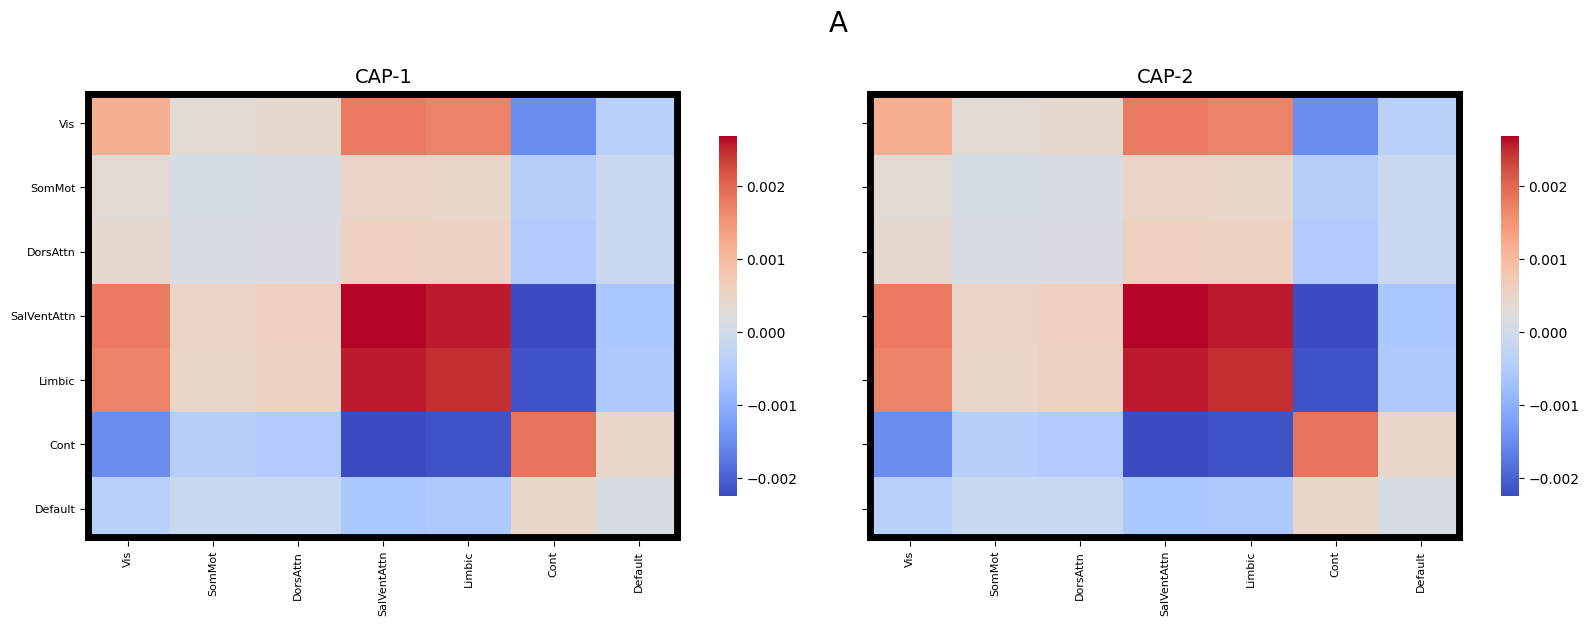

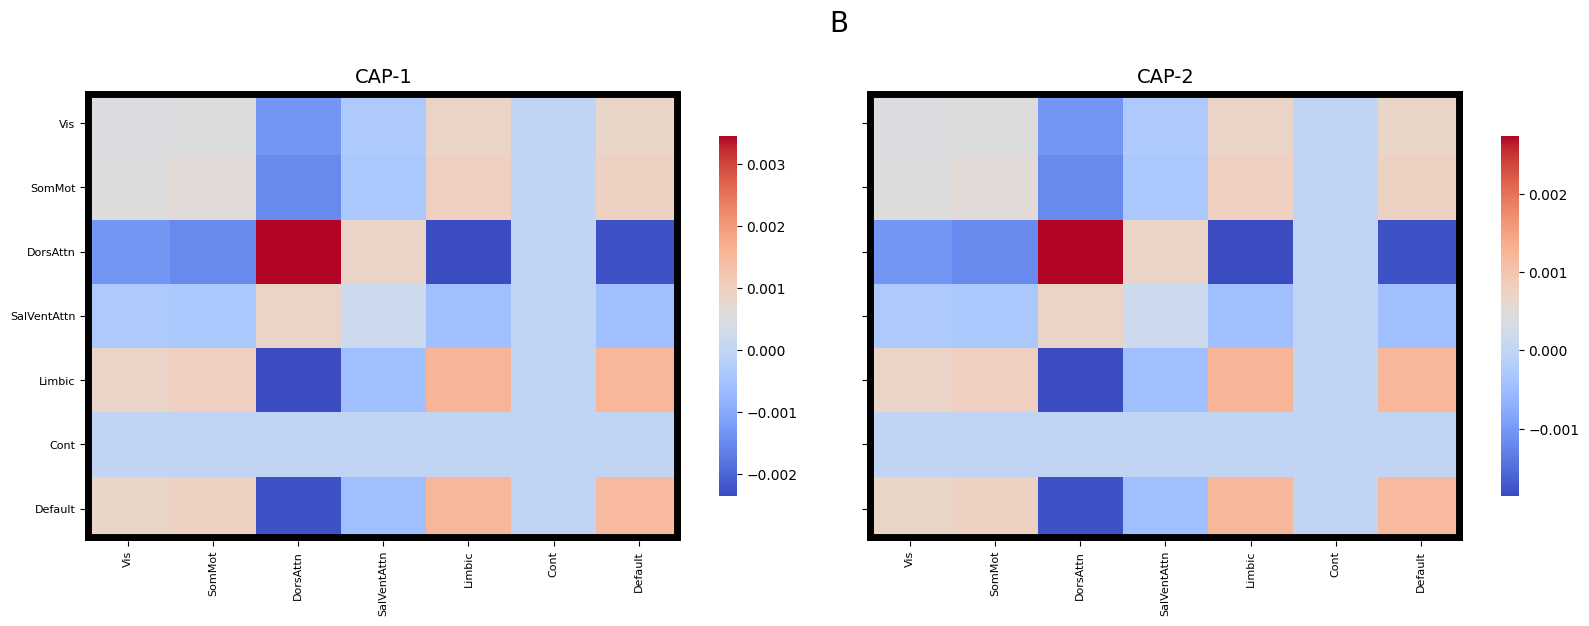

In [13]:
# Visualize Caps
#cap_analysis.caps2plot(subplots=True, xlabel_rotation=90, sharey=True, output_dir=output_dir)
cap_analysis.caps2plot(subplots=True, xlabel_rotation=90, sharey=True, borderwidths=10)

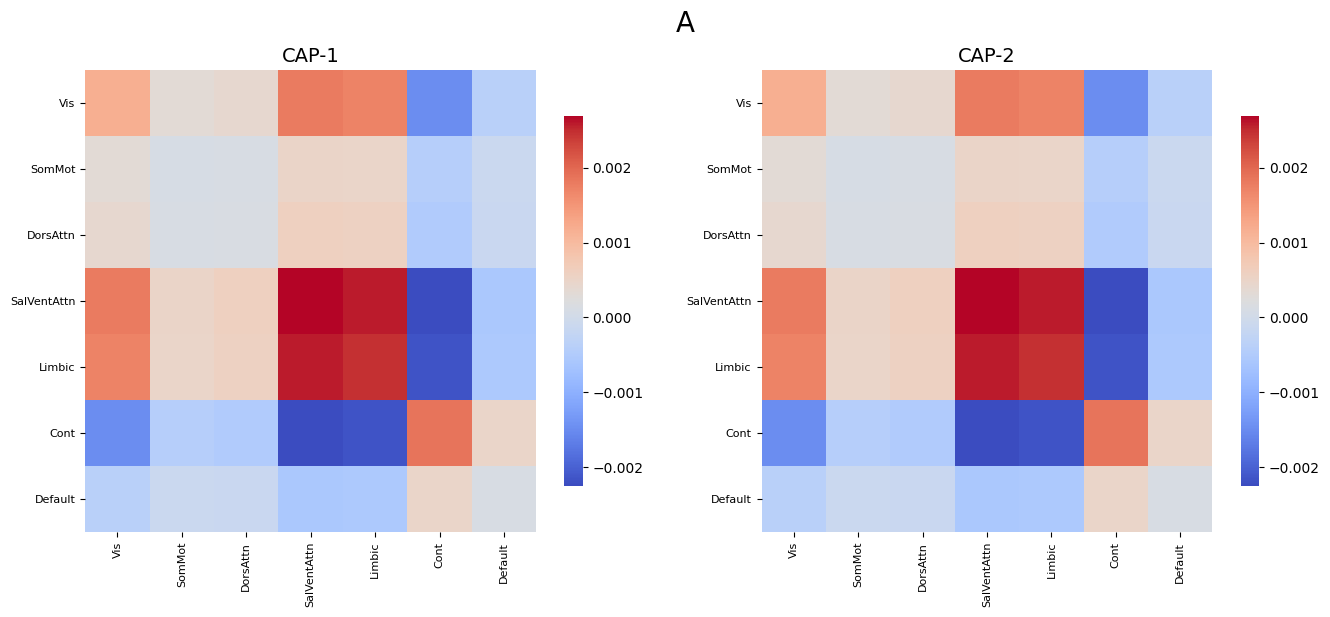

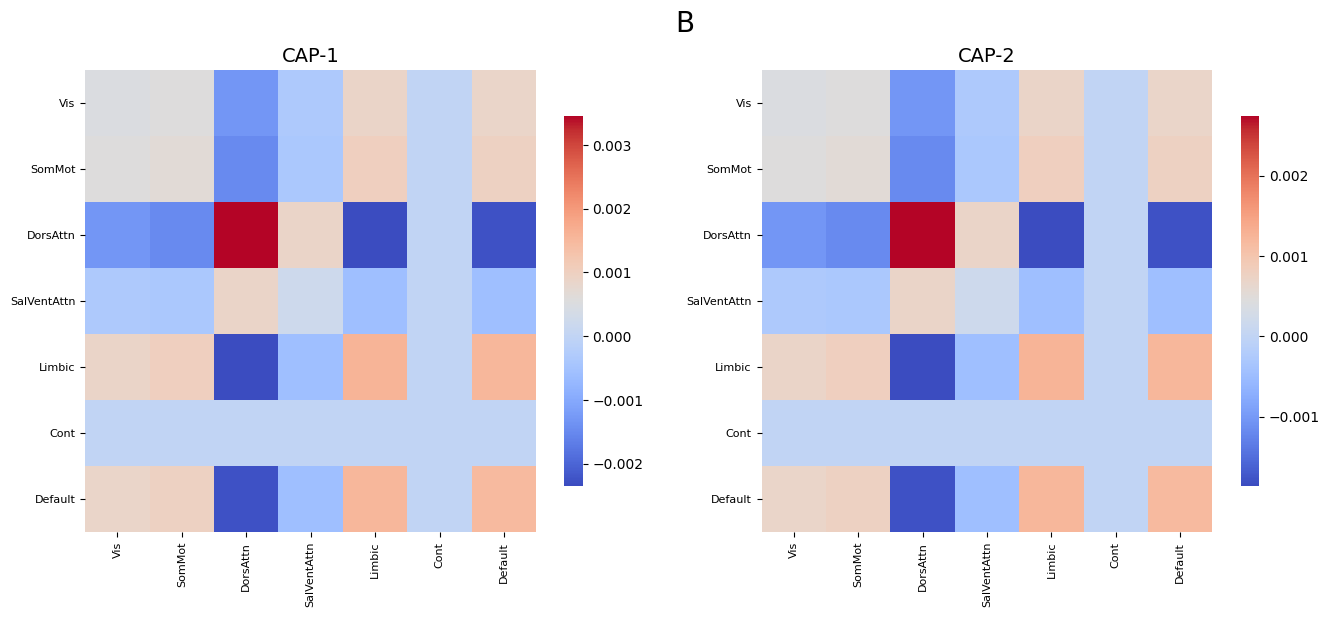

In [14]:
# Visualize Caps
cap_analysis.caps2plot(subplots=True, xlabel_rotation=90, hspace=0.6, tight_layout=False, sharey = False)

Invalid kwargs arguments used and will be ignored {'set_xlim': (-20, 120)}.


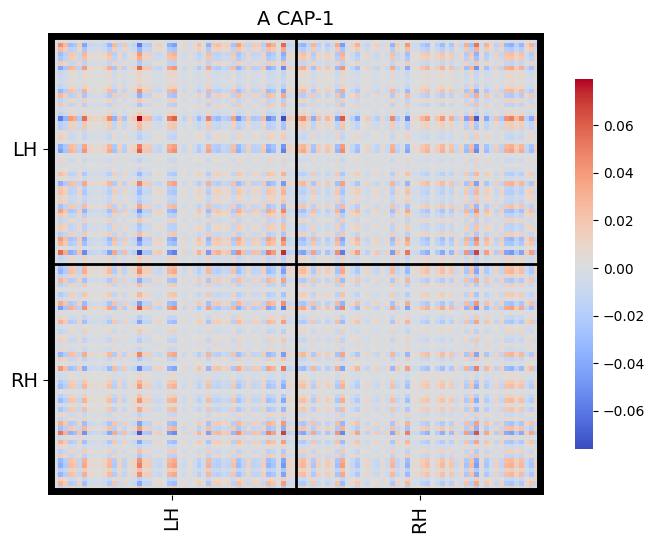

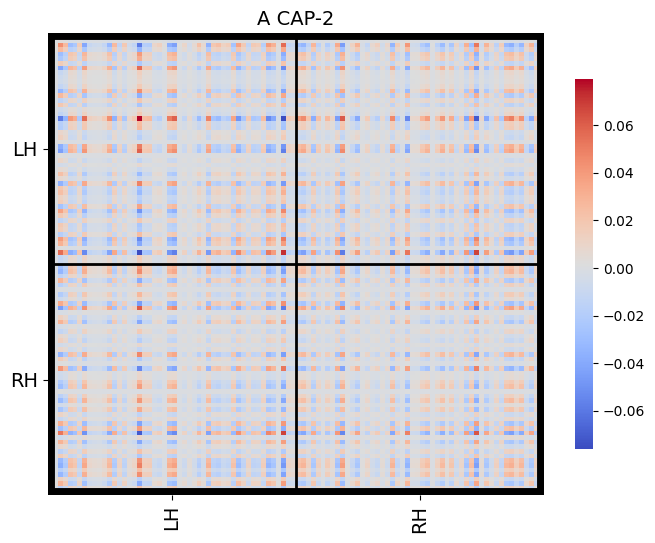

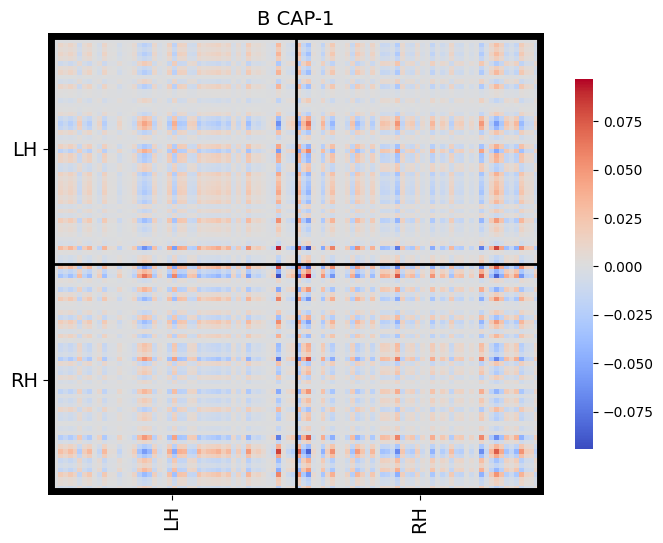

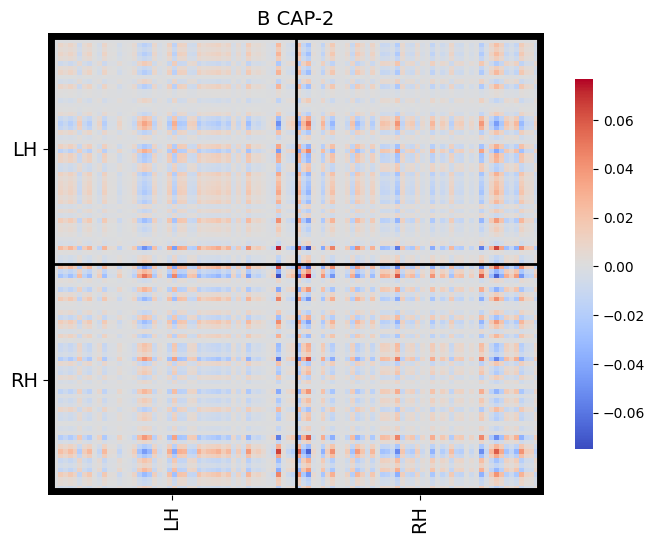

In [15]:
# Change scope from network to nodes

cap_analysis.caps2plot(subplots=False, yticklabels_size=14, wspace = 0.1, visual_scope="nodes", xlabel_rotation=90, xticklabels_size = 14, hspace = 0.6, tight_layout = False, hemisphere_labels=True, borderwidths=10, set_xlim = (-20, 120), linewidths=2)

In [16]:
cap_analysis._region_caps

{'A': {'CAP-1': array([-0.03441621, -0.00961159, -0.01151566, -0.05185971, -0.04966475,
          0.04327513,  0.01106331]),
  'CAP-2': array([ 0.03441621,  0.00961159,  0.01151566,  0.05185971,  0.04966475,
         -0.04327513, -0.01106331])},
 'B': {'CAP-1': array([-2.23126183e-02, -2.55296974e-02,  5.87756844e-02,  1.50281003e-02,
         -3.98710424e-02, -5.05271279e-06, -3.83916218e-02]),
  'CAP-2': array([ 1.98751054e-02,  2.27407389e-02, -5.23548114e-02, -1.33863750e-02,
          3.55153823e-02,  4.50073576e-06,  3.41975791e-02])}}

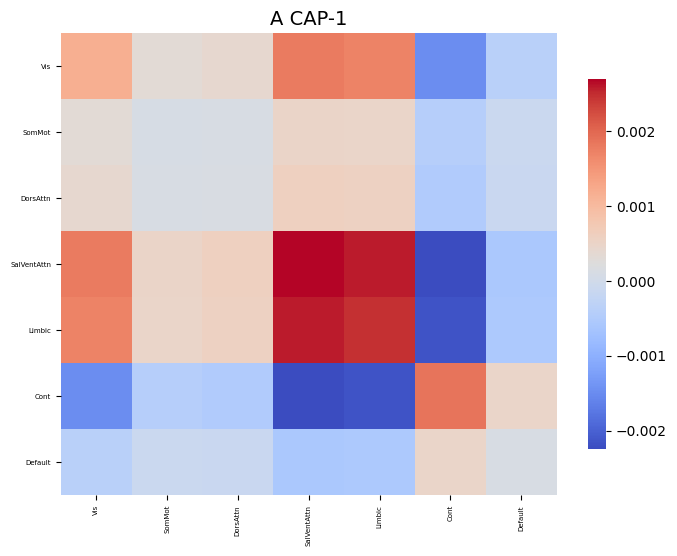

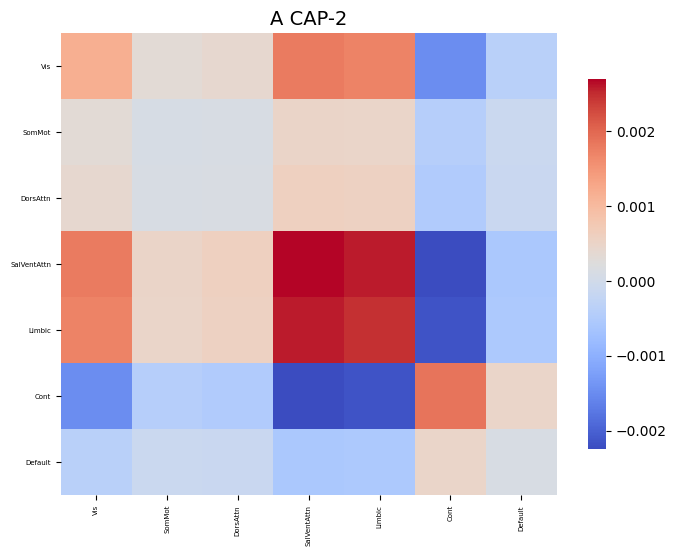

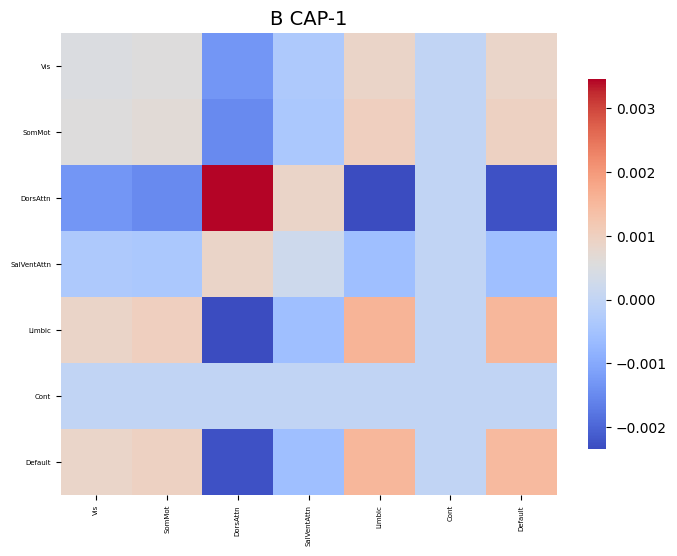

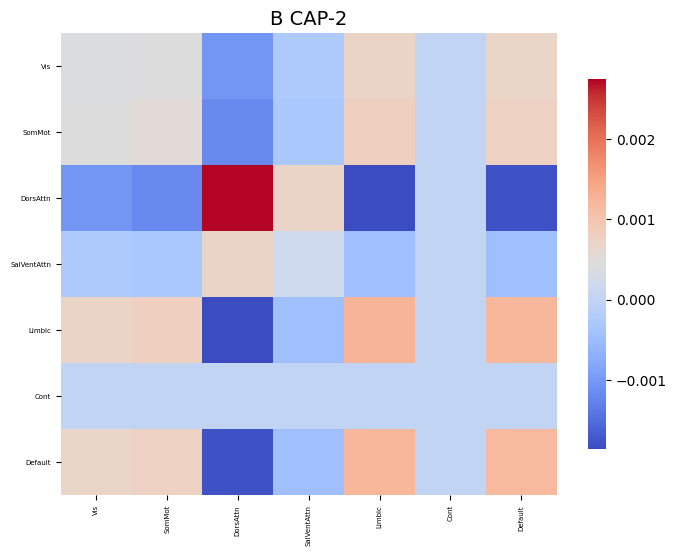

In [17]:
cap_analysis.caps2plot(subplots=False, yticklabels_size=5, wspace = 0.1, visual_scope="regions", xlabel_rotation=90, xticklabels_size = 5, hspace = 0.6, tight_layout = False)

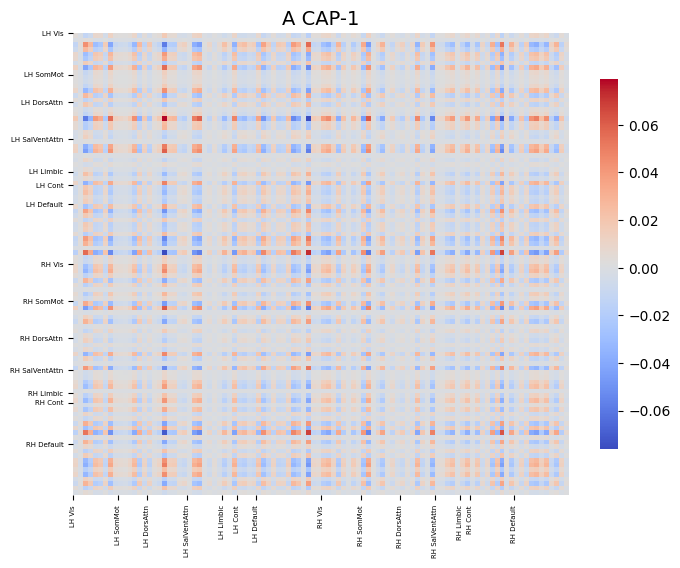

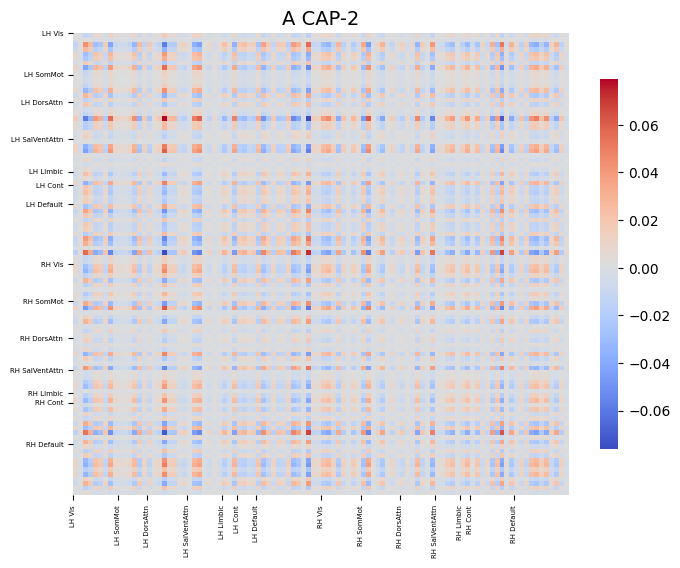

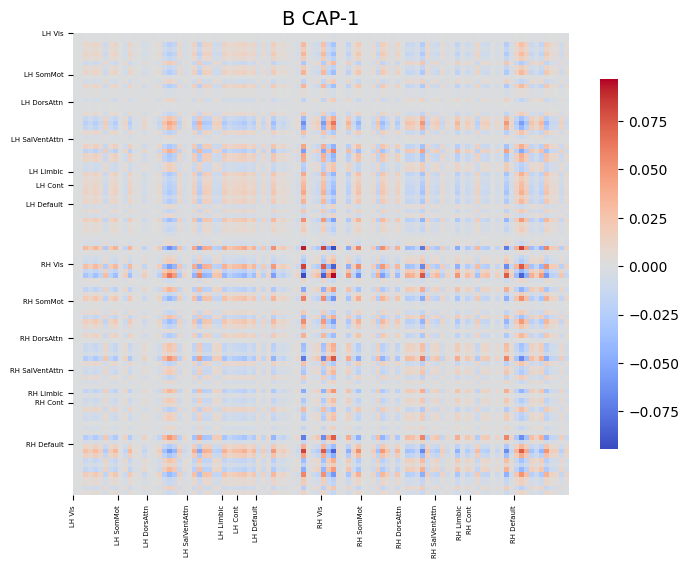

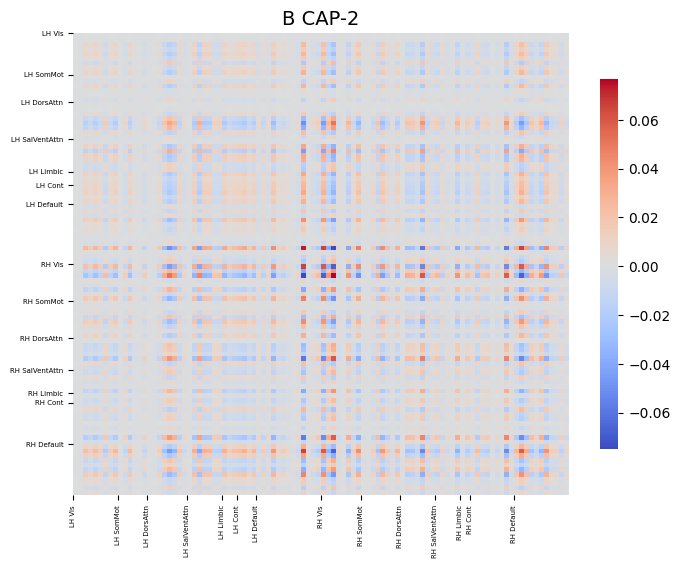

In [18]:
cap_analysis.caps2plot(subplots=False, yticklabels_size=5, wspace = 0.1, visual_scope="nodes", xlabel_rotation=90, xticklabels_size = 5, hspace = 0.6, tight_layout = False)

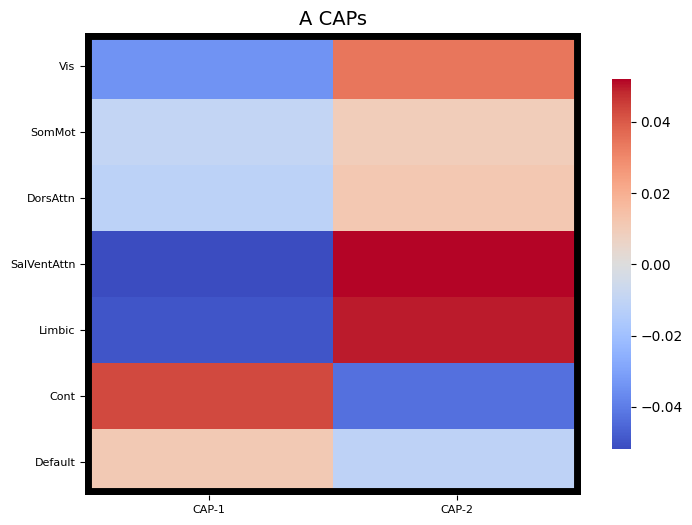

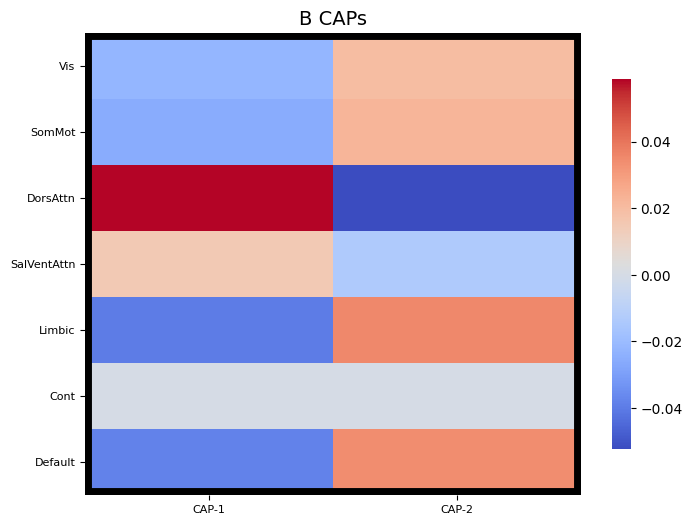

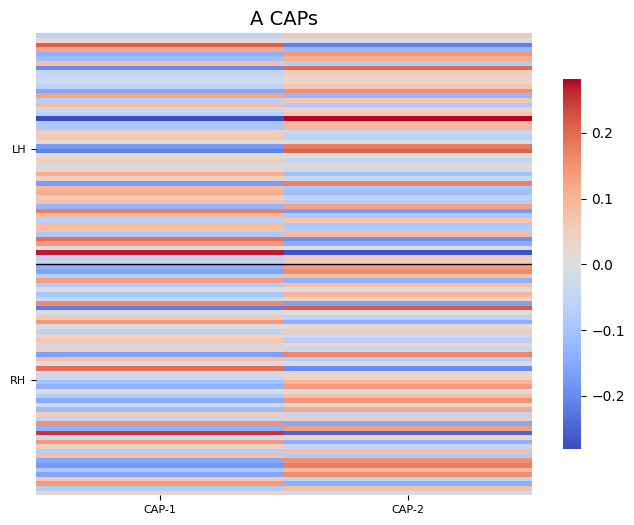

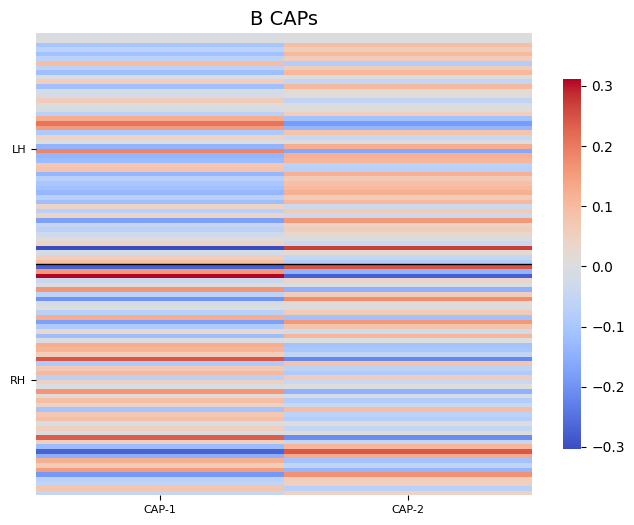

In [19]:
# Get regular heatmap 
cap_analysis.caps2plot(subplots=True, visual_scope="regions", plot_options="heatmap", borderwidths=10)
cap_analysis.caps2plot(subplots=True, visual_scope="nodes", plot_options="heatmap", hemisphere_labels = True)

In [20]:
# Calculate cap metrics
# cap_analysis.calculate_metrics(subject_timeseries=extractor.subject_timeseries,tr=2,metrics="persistence",return_df=True, output_dir=output_dir, file_name="Group_CAPs_metrics")
cap_analysis.calculate_metrics(subject_timeseries=extractor.subject_timeseries,tr=2,metrics="persistence",return_df=True)

{'persistence':    Subject_ID Group    Run     CAP-1     CAP-2
 0           1     A  run-1  3.166667  5.166667
 1           1     A  run-2  3.733333  3.142857
 2           1     A  run-3  4.000000  4.727273
 3           2     A  run-1  3.142857  3.733333
 4           2     A  run-2  4.500000  4.181818
 5           2     A  run-3  3.733333  3.142857
 6           3     A  run-1  4.166667  4.166667
 7           3     A  run-2  4.000000  3.692308
 8           3     A  run-3  3.857143  3.285714
 9           5     A  run-1  3.692308  3.714286
 10          5     A  run-2  4.000000  4.666667
 11          5     A  run-3  4.307692  3.384615
 12          4     B  run-1  2.933333  4.000000
 13          4     B  run-2  4.153846  3.538462
 14          4     B  run-3  4.153846  3.538462
 15          6     B  run-1  3.076923  4.615385
 16          6     B  run-2  4.545455  4.545455
 17          6     B  run-3  4.000000  3.692308
 18          7     B  run-1  4.363636  4.727273
 19          7     B  run

Invalid kwargs arguments used and will be ignored {'y': -3}.


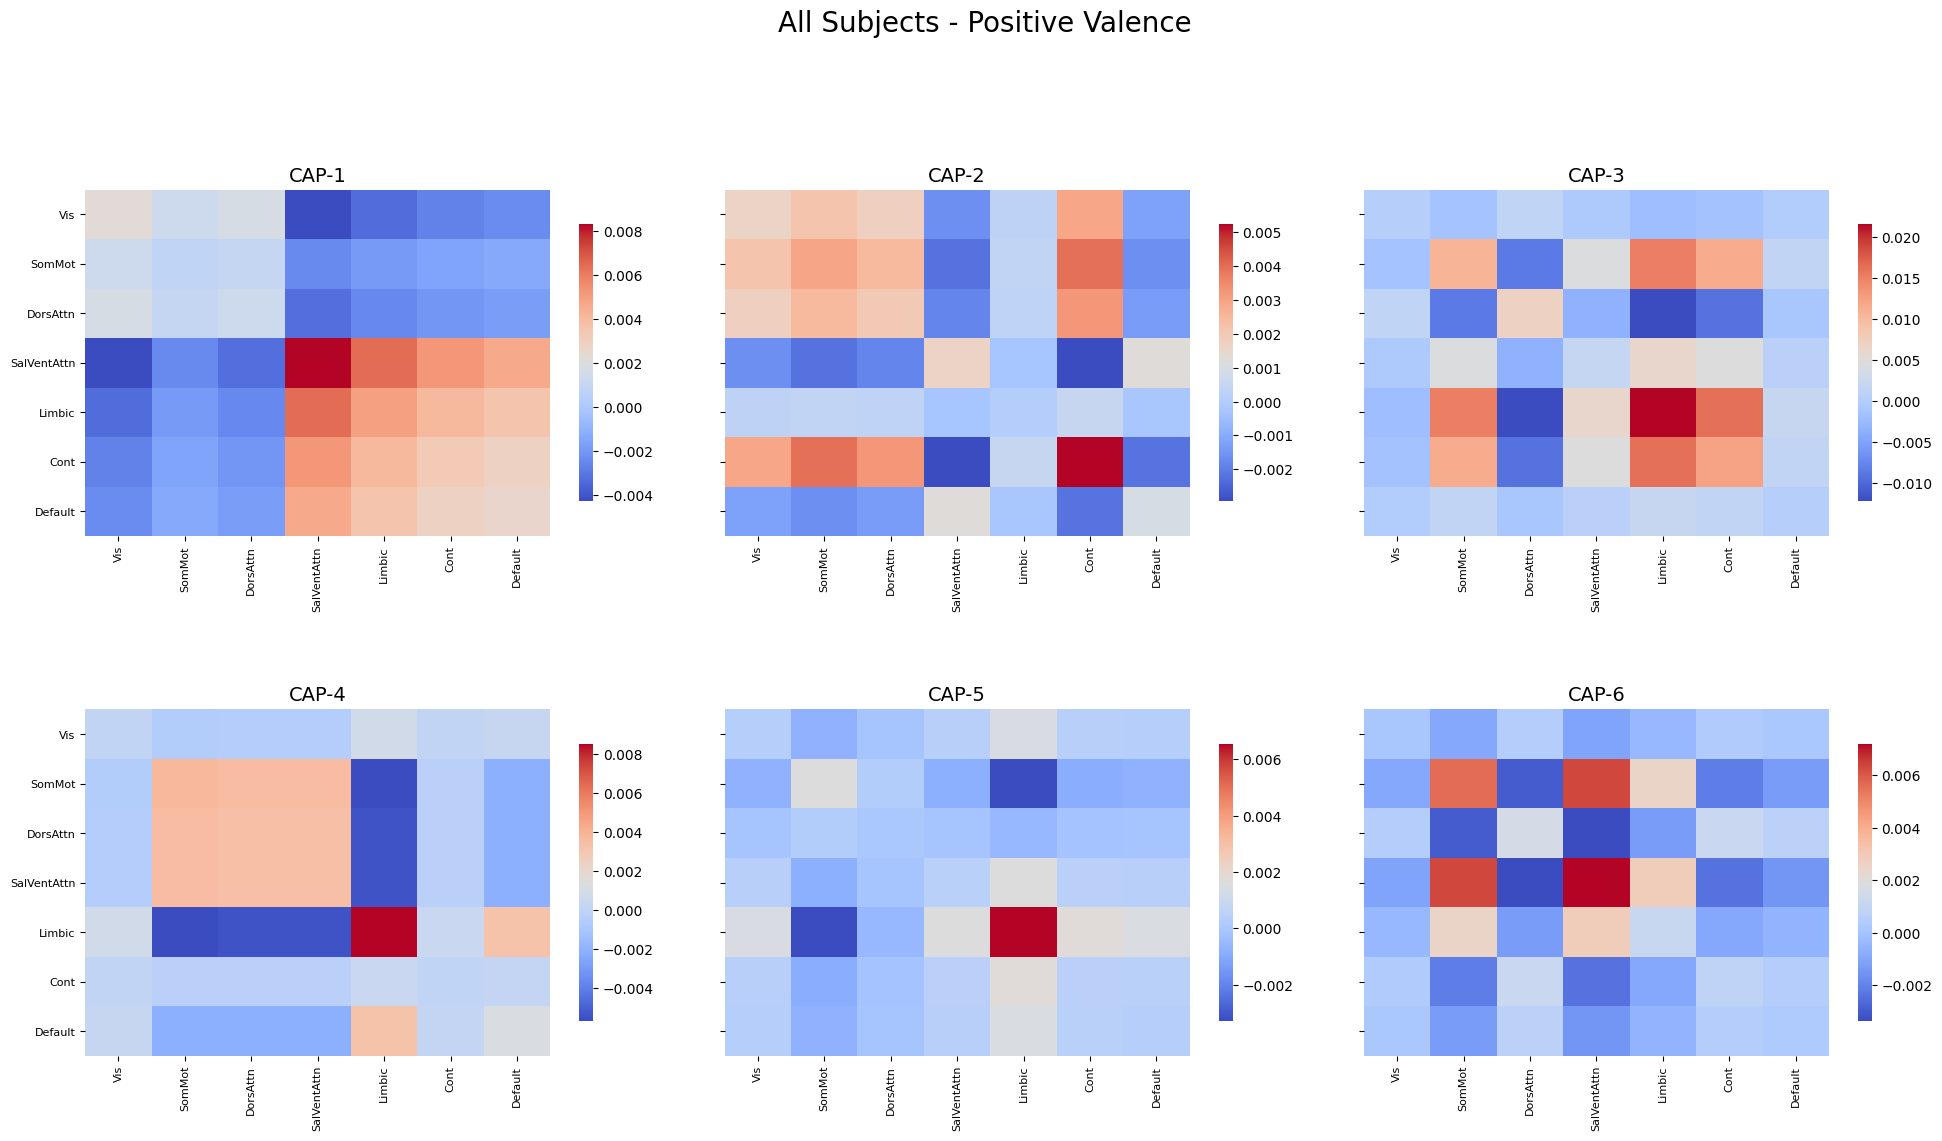

In [21]:
# Performing Cap analysis without groups or cluster selection method

cap_analysis = CAP(parcel_approach=extractor.parcel_approach, n_clusters=6)
cap_analysis.get_caps(subject_timeseries="sample_for_neurocaps_demo_timeseries.pkl")

# Invalid plotting keywords will be ignored and plotting will continue
cap_analysis.caps2plot(subplots=True, wspace = 0.1, hspace = 0.5, ncol=3, suffix_title="- Positive Valence", y = -3, xlabel_rotation=90, tight_layout=False, yticklabels_size=8, xticklabels_size=8)

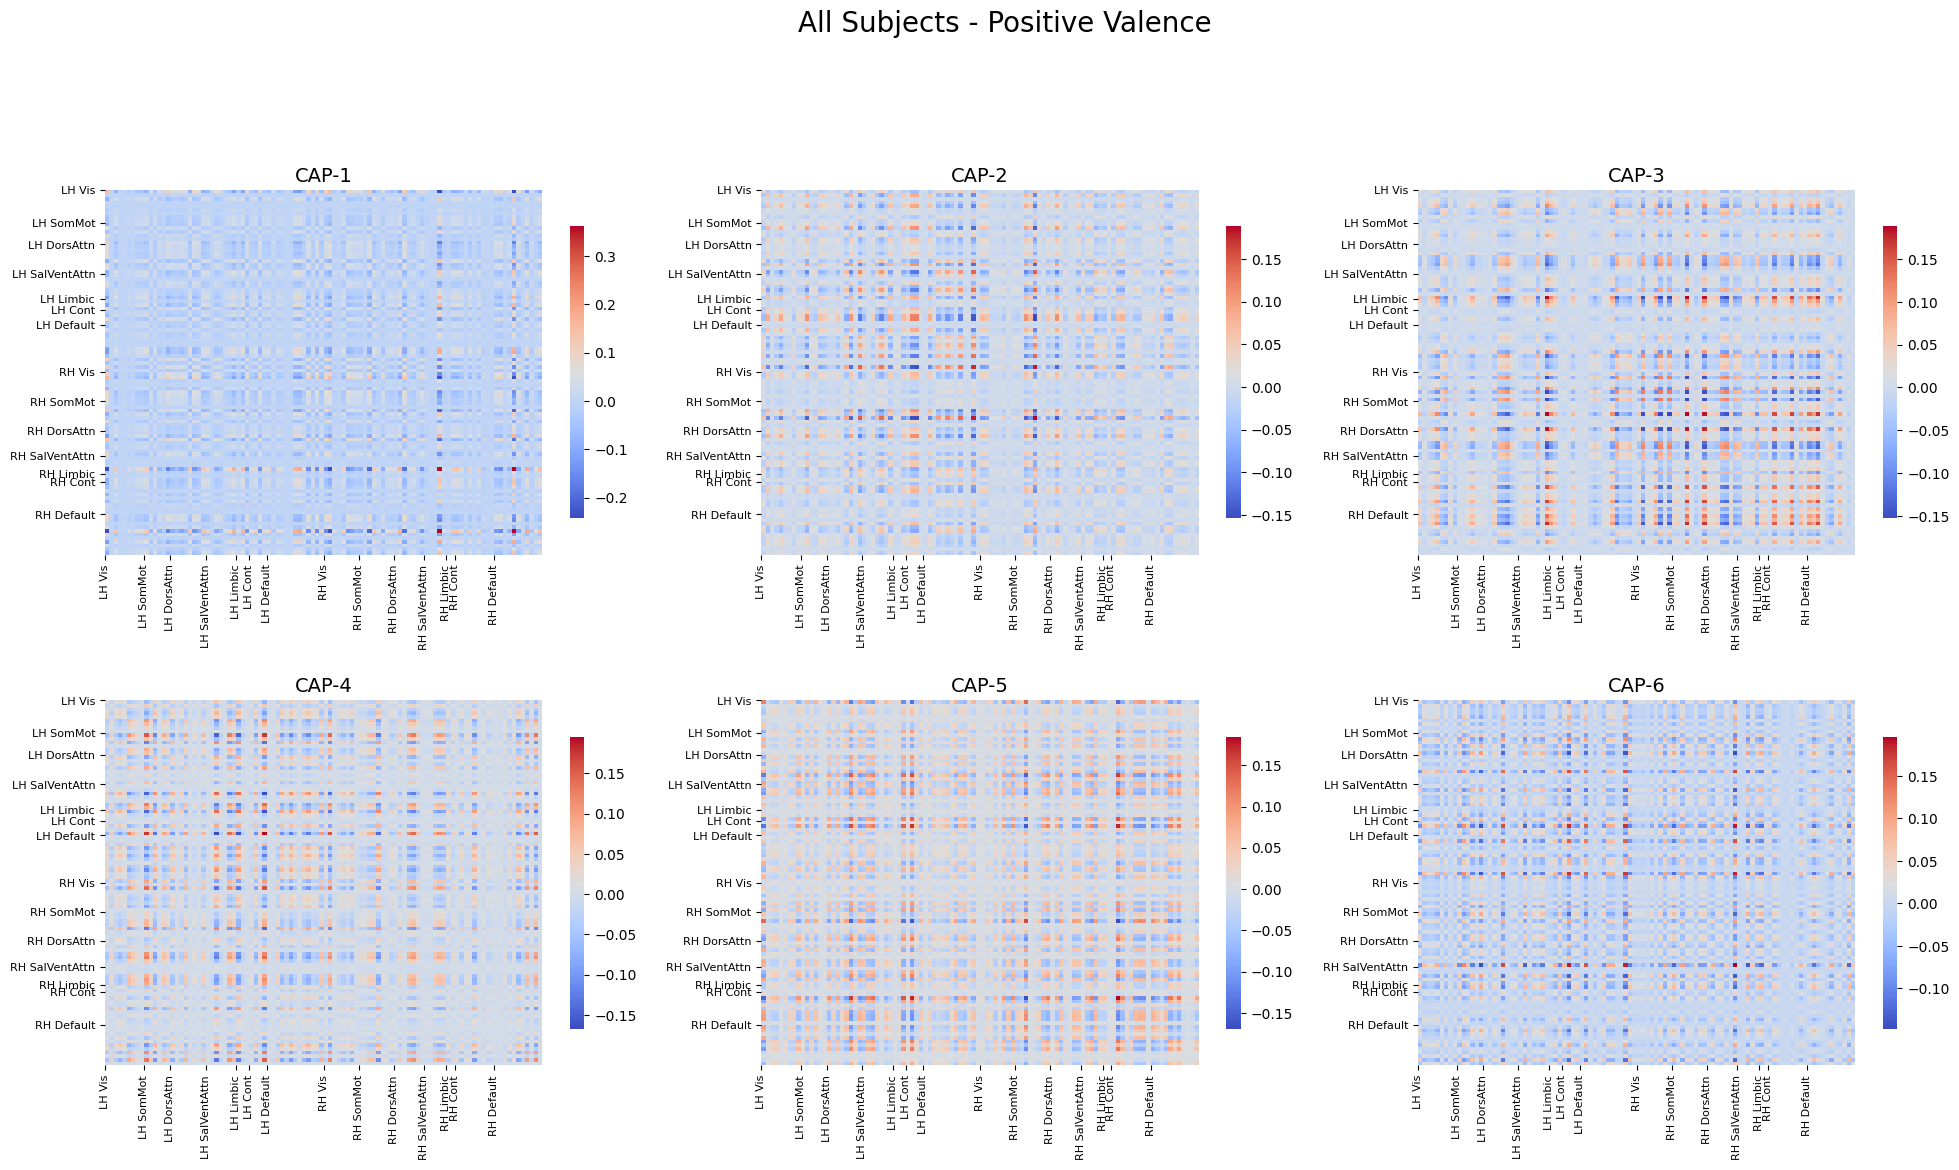

In [22]:
cap_analysis.caps2plot(visual_scope="nodes", plot_options="outer product", suffix_title="- Positive Valence", ncol=3, sharey=False, subplots=True, xlabel_rotation = 90, tight_layout=False, hspace = 0.4)

In [23]:
# Individual plots. In the event you wnat to merge TRs from two dictionaries conatining the same subject to find common CAPs across a task
subject_timeseries_1 = {str(x) : {f"run-{y}": np.random.rand(100,ncol) for y in range(1,4)} for x in range(1,11)}
subject_timeseries_2 = {str(x) : {f"run-{y}": np.random.rand(100,ncol) for y in range(1,4)} for x in range(1,7)}
# Includes `output_dir` and `file_name` parameters to save merge dictionary as a pickle file

# Returns combined dictionary as well as the reduced subject dictionaries containing only the subjects present in the combined
all_dicts = merge_dicts(subject_timeseries_list=[subject_timeseries_1, subject_timeseries_2], return_combined_dict=True, return_reduced_dicts=True)
# Only the combined subject dictionary
subject_timeseries_combined = merge_dicts(subject_timeseries_list=[subject_timeseries_1, subject_timeseries_2], return_combined_dict=True, return_reduced_dicts=False)

print(all_dicts["dict_0"].keys())
print(all_dicts["dict_1"].keys())
print(all_dicts["combined"].keys())

dict_keys(['1', '2', '3', '4', '5', '6'])
dict_keys(['1', '2', '3', '4', '5', '6'])
dict_keys(['1', '2', '3', '4', '5', '6'])


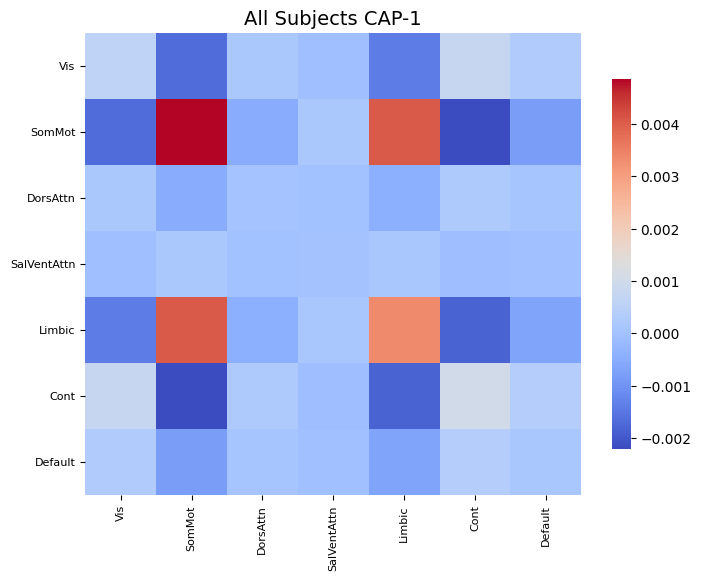

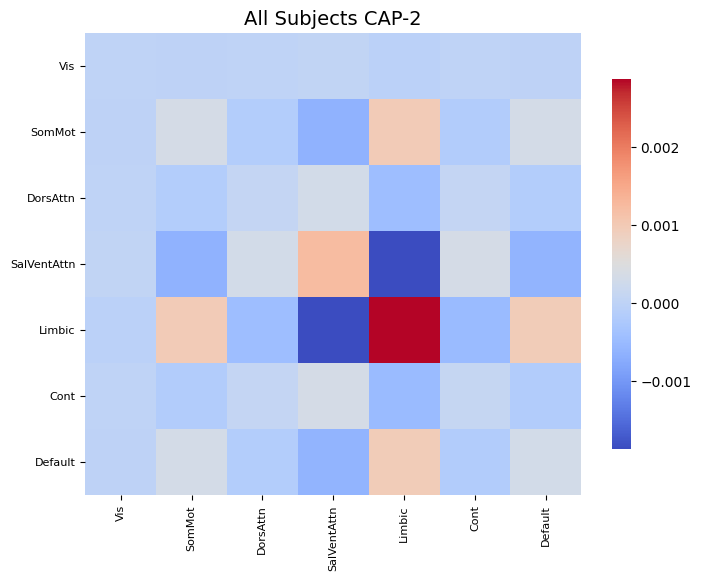

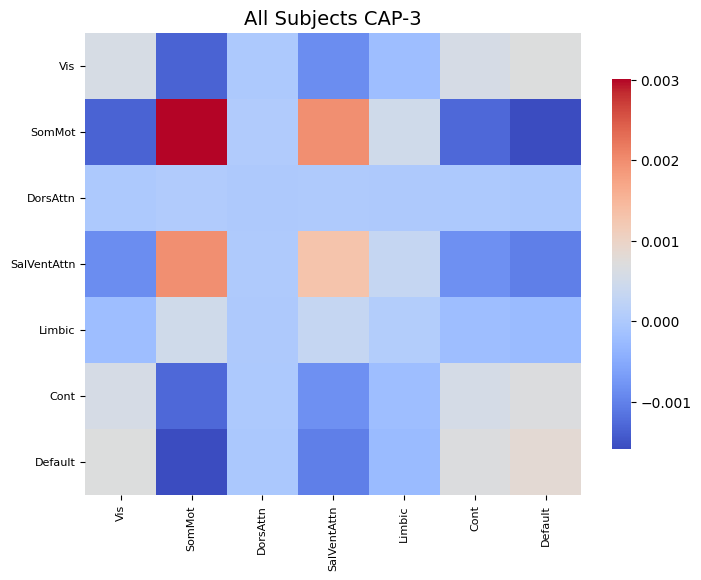

In [24]:
cap_analysis = CAP(parcel_approach=extractor.parcel_approach, n_clusters=3)
cap_analysis.get_caps(subject_timeseries=subject_timeseries_combined)
cap_analysis.caps2plot(xlabel_rotation=90)

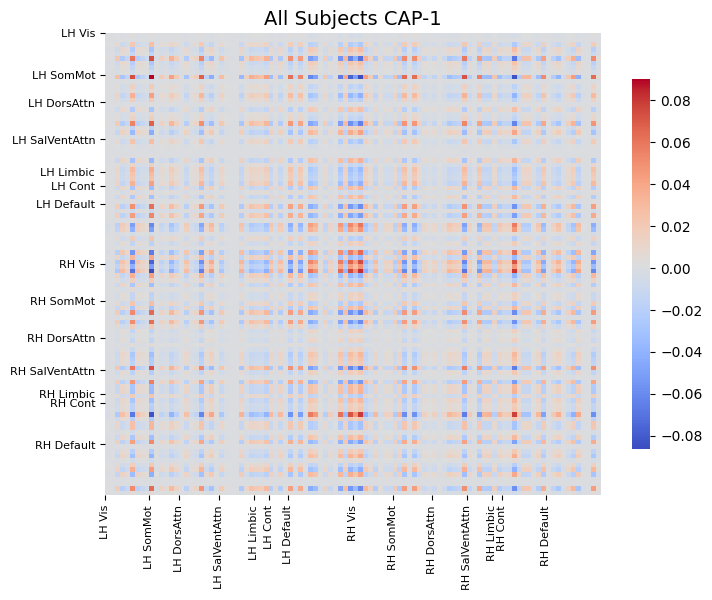

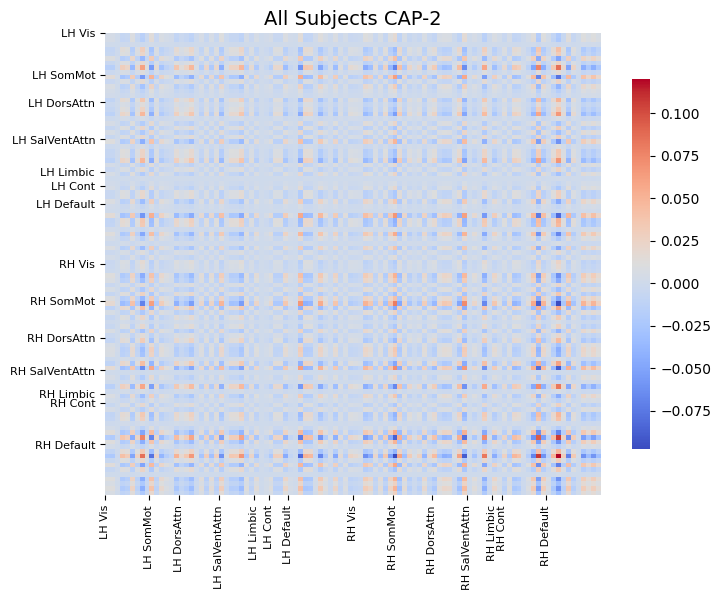

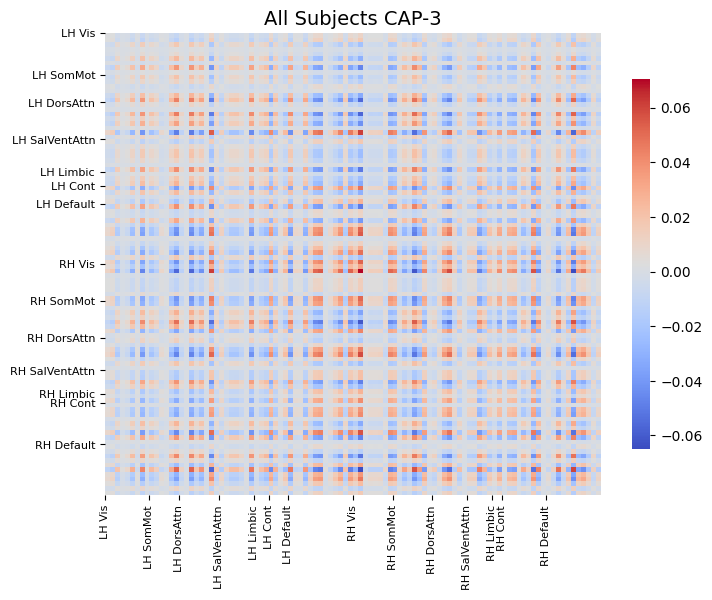

In [25]:
cap_analysis.caps2plot(visual_scope="nodes", plot_options="outer product", xlabel_rotation = 90)

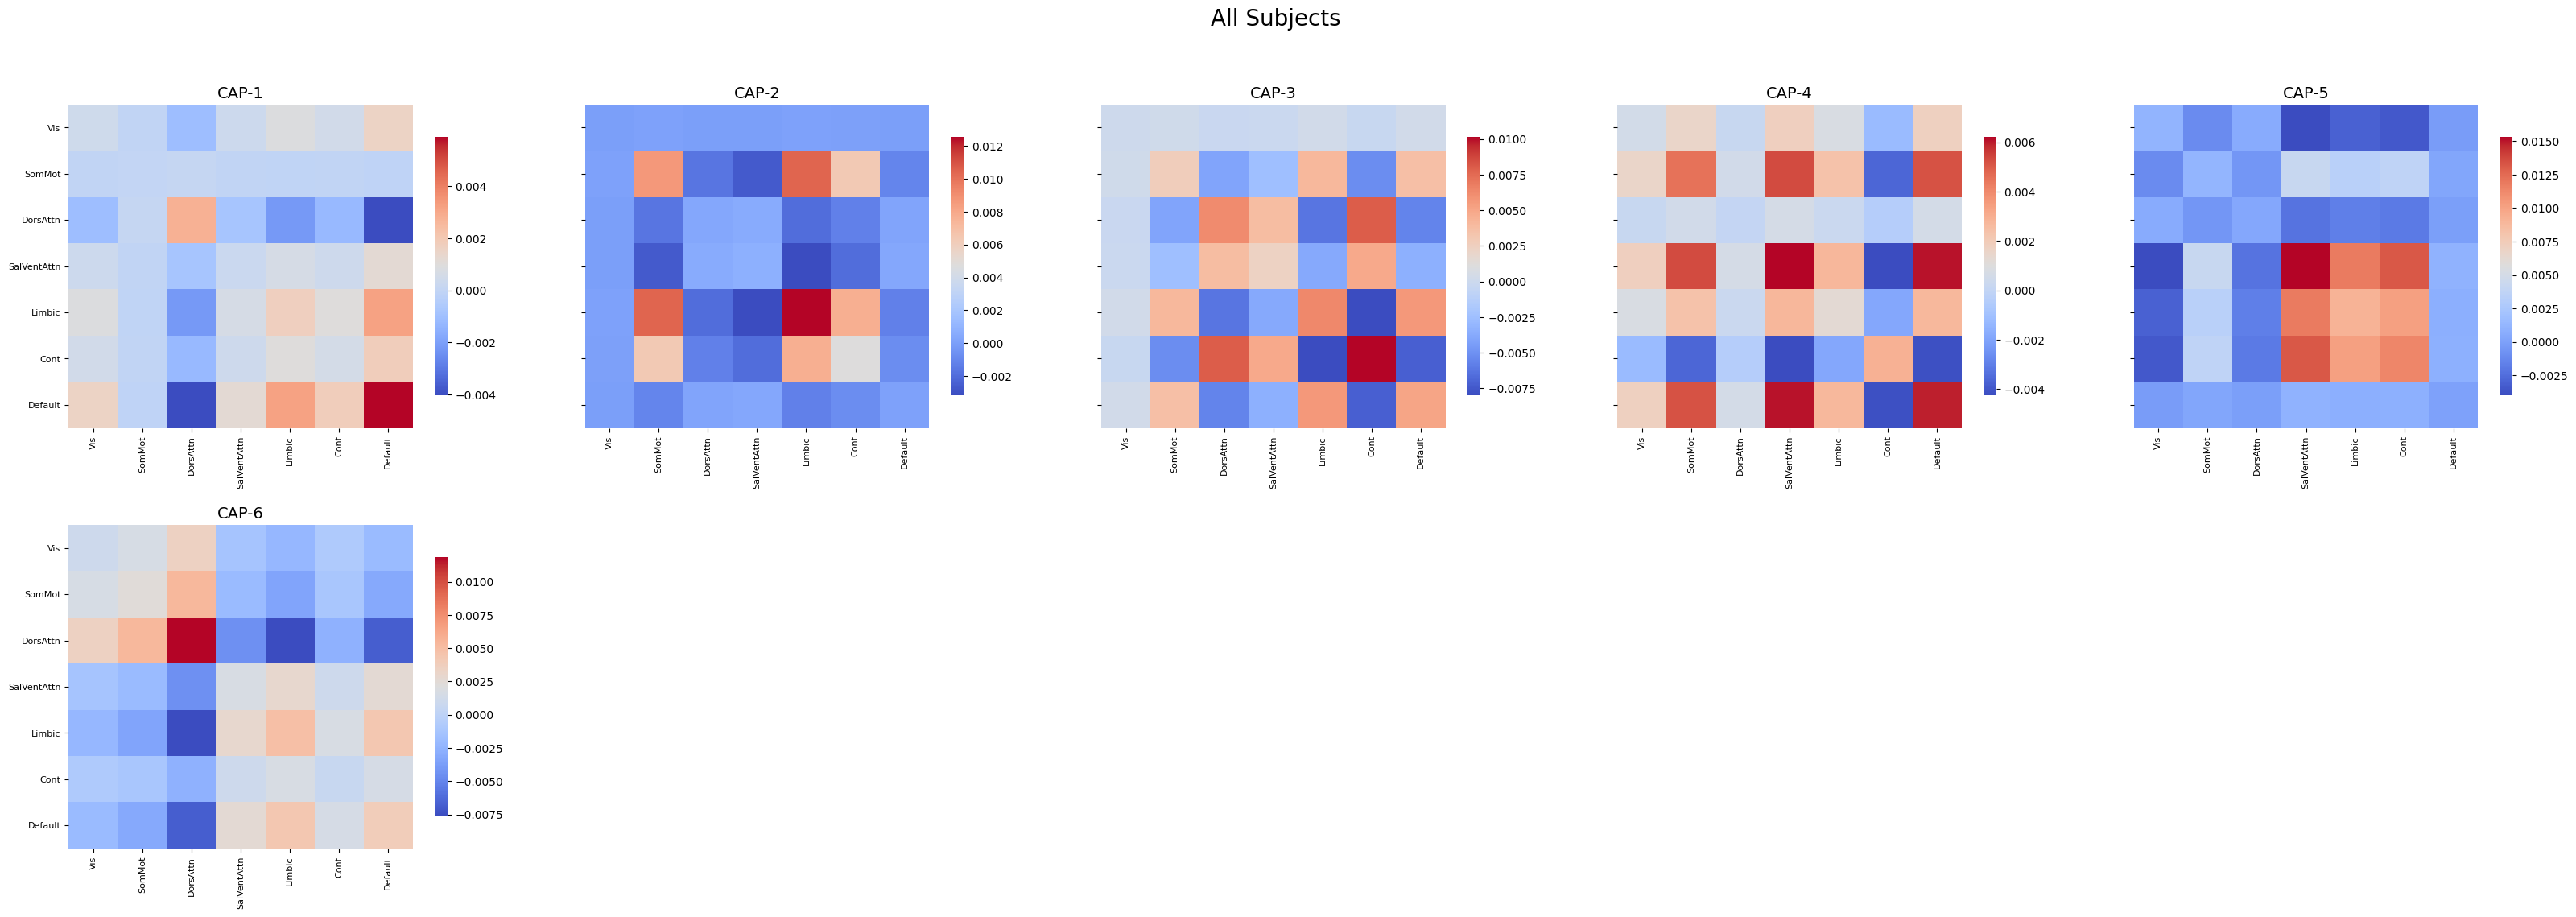

In [26]:
# Performing Caps analysis with no groups and no cluster selection method
cap_analysis = CAP(parcel_approach=extractor.parcel_approach, n_clusters=6)
cap_analysis.get_caps(subject_timeseries=extractor.subject_timeseries)
cap_analysis.caps2plot(visual_scope="regions", plot_options="outer product", subplots=True, fontsize=14, xlabel_rotation=90, tight_layout=False, hspace=0.3)

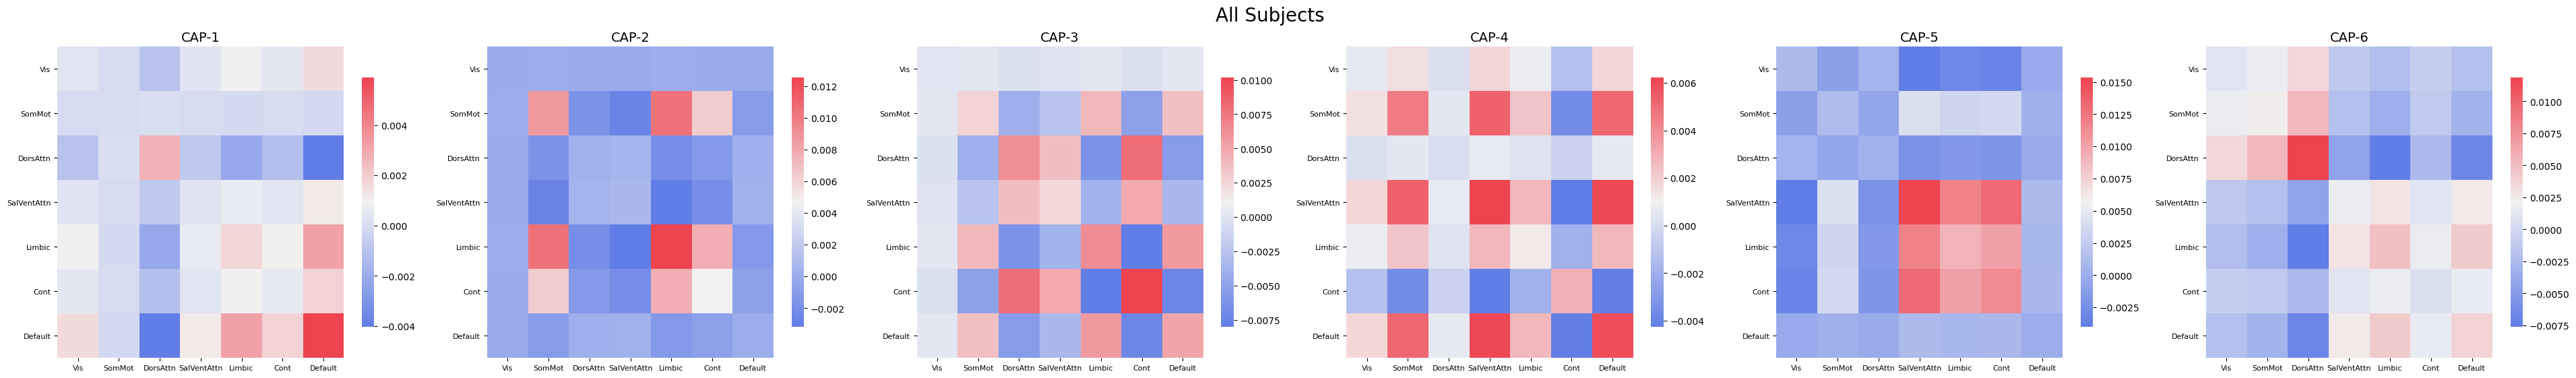

In [27]:
# Can change the number of columns for subplots. If none is specified, the default varies but will max out to five columns; however, you can specify more than five columns
#cap_analysis.caps2plot(output_dir=output_dir, visual_scope="regions", plot_options="outer product", subplots=True, fontsize=14, ncol=3, xlabel_rotation=90, tight_layout=False,  hspace = 0.3)
import seaborn as sns

sns.diverging_palette(145, 300, s=60, as_cmap=True)
palette = sns.diverging_palette(260, 10, s=80, l=55, n=256, as_cmap=True)
cap_analysis.caps2plot(visual_scope="regions", plot_options="outer product", subplots=True, fontsize=14, ncol=6, sharey=False, tight_layout=False, xlabel_rotation=0, hspace = 0.3, cmap=palette)

In [28]:
help(cap_analysis.caps2plot)

Help on method caps2plot in module neurocaps.analysis.cap:

caps2plot(output_dir: str = None, plot_options: Union[str, list[str]] = 'outer product', visual_scope: list[str] = 'regions', suffix_title: str = None, show_figs: bool = True, subplots: bool = False, **kwargs) -> None method of neurocaps.analysis.cap.CAP instance
    Generate heatmaps and outer product plots of CAPs
    
    This function produces seaborn heatmaps for each CAP. If groups were given when the CAP class was initialized, plotting will be done for all CAPs for all groups.
    
    Parameters
    ----------
    output_dir: str, default=None
        Directory to save plots to. The directory will be created if it does not exist. If None, plots will not be saved.
    plot_options: str or list[str], default="outer product"
        Type of plots to create. Options are "outer product" or "heatmap".
    visual_scope: str or list[str], default="regions"
        Determines whether plotting is done at the region level or node

In [29]:
#output = cap_analysis.calculate_metrics(subject_timeseries=extractor.subject_timeseries,return_df=True,output_dir=output_dir, runs=[1,2],file_name="All_Subjects_CAPs_metrics")
output = cap_analysis.calculate_metrics(subject_timeseries=extractor.subject_timeseries,return_df=True, runs=[1,2])
output["temporal fraction"]

,Subject_ID,Group,Run,CAP-1,CAP-2,CAP-3,CAP-4,CAP-5,CAP-6
0,1,All Subjects,run-1,0.14,0.12,0.06,0.26,0.20,0.22
1,1,All Subjects,run-2,0.12,0.14,0.08,0.18,0.22,0.26
2,2,All Subjects,run-1,0.26,0.12,0.24,0.18,0.08,0.12
3,2,All Subjects,run-2,0.14,0.12,0.24,0.16,0.20,0.14
4,3,All Subjects,run-1,0.16,0.20,0.24,0.12,0.06,0.22
5,3,All Subjects,run-2,0.10,0.12,0.24,0.20,0.16,0.18
6,4,All Subjects,run-1,0.12,0.14,0.10,0.18,0.22,0.24
7,4,All Subjects,run-2,0.14,0.08,0.20,0.16,0.20,0.22
8,5,All Subjects,run-1,0.10,0.18,0.16,0.12,0.14,0.30
9,5,All Subjects,run-2,0.12,0.10,0.16,0.12,0.32,0.18


In [30]:
#output = cap_analysis.calculate_metrics(subject_timeseries=extractor.subject_timeseries,return_df=True, output_dir=output_dir, runs=[1,2], continuous_runs=True, file_name="All_Subjects_CAPs_metrics")
cap_analysis.calculate_metrics(subject_timeseries=extractor.subject_timeseries,return_df=True, runs=[1,2], continuous_runs=True)
output["temporal fraction"]

,Subject_ID,Group,Run,CAP-1,CAP-2,CAP-3,CAP-4,CAP-5,CAP-6
0,1,All Subjects,run-1,0.14,0.12,0.06,0.26,0.20,0.22
1,1,All Subjects,run-2,0.12,0.14,0.08,0.18,0.22,0.26
2,2,All Subjects,run-1,0.26,0.12,0.24,0.18,0.08,0.12
3,2,All Subjects,run-2,0.14,0.12,0.24,0.16,0.20,0.14
4,3,All Subjects,run-1,0.16,0.20,0.24,0.12,0.06,0.22
5,3,All Subjects,run-2,0.10,0.12,0.24,0.20,0.16,0.18
6,4,All Subjects,run-1,0.12,0.14,0.10,0.18,0.22,0.24
7,4,All Subjects,run-2,0.14,0.08,0.20,0.16,0.20,0.22
8,5,All Subjects,run-1,0.10,0.18,0.16,0.12,0.14,0.30
9,5,All Subjects,run-2,0.12,0.10,0.16,0.12,0.32,0.18


In [31]:
help(cap_analysis.calculate_metrics)

Help on method calculate_metrics in module neurocaps.analysis.cap:

calculate_metrics(subject_timeseries: Union[dict[dict[numpy.ndarray]], str], tr: float = None, runs: int = None, continuous_runs: bool = False, metrics: Union[str, list[str]] = ['temporal fraction', 'persistence', 'counts', 'transition frequency'], return_df: bool = True, output_dir: str = None, file_name: str = None) -> dict method of neurocaps.analysis.cap.CAP instance
    Get CAPs metrics
    
    Creates a single pandas DataFrame containing CAP metrics for all participants, as described in Liu et al., 2018 and Yang et al., 2021. 
    The metrics include:
    
    - 'temporal fraction': The proportion of total volumes spent in a single CAP over all volumes in a run.
    - 'persistence;: The average time spent in a single CAP before transitioning to another CAP (average consecutive/uninterrupted time).
    - 'counts': The frequency of each CAP observed in a run.
    - 'transition frequency': The number of switches be

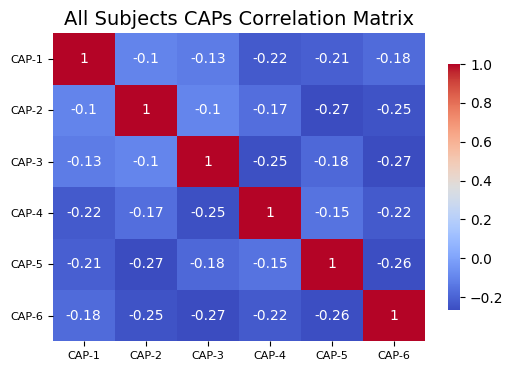

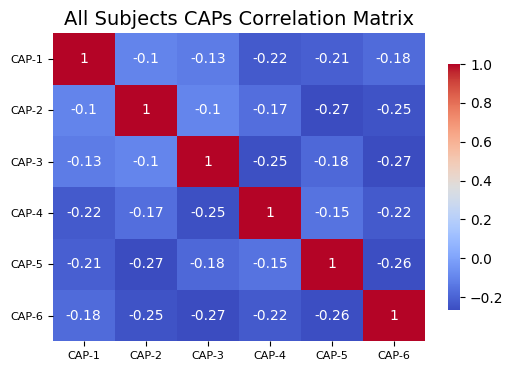

In [32]:
#cap_analysis.caps2corr(annot=True, output_dir=output_dir)
cap_analysis.caps2corr(annot=True ,figsize=(6,4))

import seaborn as sns
palette = sns.diverging_palette(260, 10, s=80, l=55, n=256, as_cmap=True)
cap_analysis.caps2corr(annot=True ,figsize=(6,4))

Invalid kwargs arguments used and will be ignored {'cbar_location': 'bottom'}.


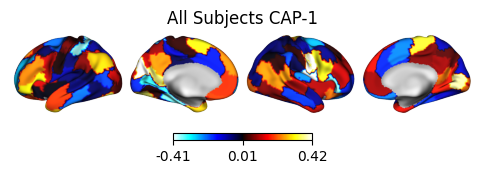

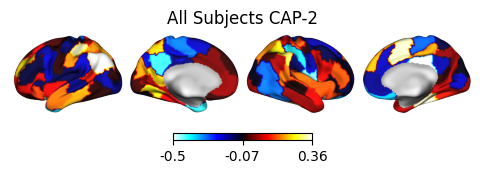

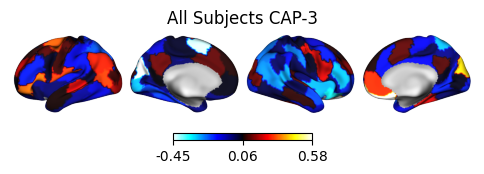

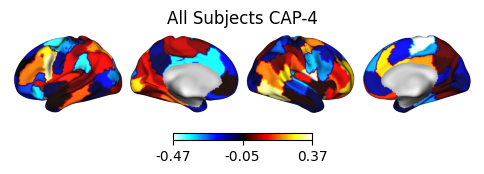

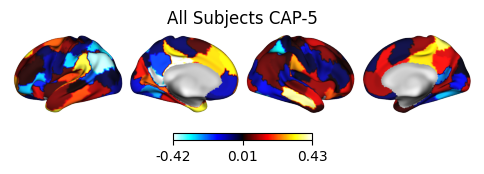

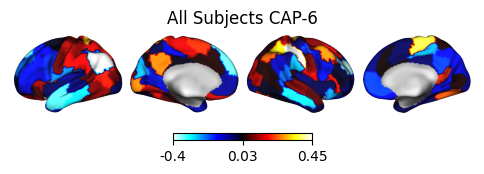

In [33]:
# If you experience coverage issues, usually smoothing helps to mitigate these issues

#cap_analysis.caps2surf(fwhm=1, output_dir=output_dir,save_stat_map=True)

file = cap_analysis.caps2surf(cmap="cold_hot", layout="row",  size=(500, 100), cbar_location="bottom")

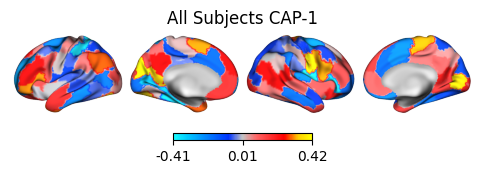

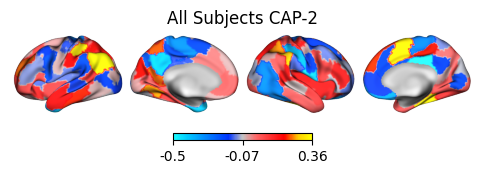

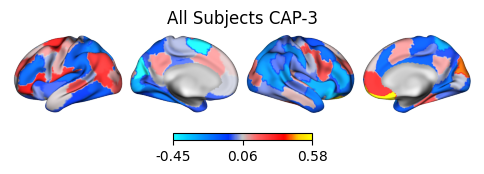

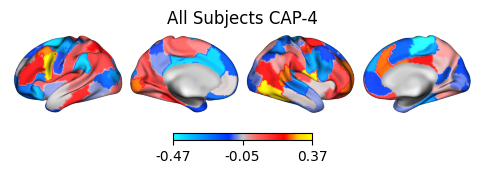

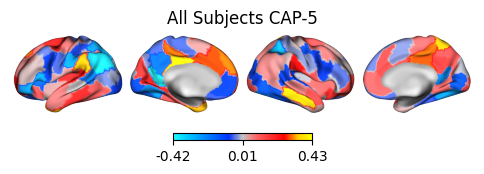

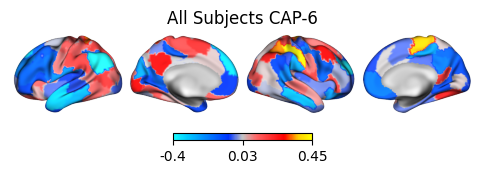

In [34]:
from matplotlib.colors import LinearSegmentedColormap
colors = ["#1bfffe", "#00ccff", "#0099ff", "#0066ff", "#0033ff", "#c4c4c4", "#ff6666", 
          "#ff3333", "#FF0000","#ffcc00","#FFFF00"]

# Create the colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cold_hot", colors, N=256)
cap_analysis.caps2surf(cmap=custom_cmap, size=(500, 100), layout="row")

In [35]:
radialaxis={"showline": True, "linewidth": 2, "linecolor": "rgba(0, 0, 0, 0.25)", "gridcolor": "rgba(0, 0, 0, 0.25)", "ticks": "outside" , "tickfont": {"size": 14, "color": "black"},
"range": [0,0.3], "tickvals": [0.1,0.2,0.3]}
#cap_analysis.caps2radar(radialaxis=radialaxis, fill="toself", scattersize=10, output_dir = output_dir)
cap_analysis.caps2radar(radialaxis=radialaxis, fill="toself", scattersize=10)

In [36]:
# Can save caps a nifti statistical maps
#cap_analysis.caps2niftis(output_dir=output_dir)

In [37]:
# If the statistical maps were converted to gifti using some other tool such as connectome workben
#x = CAP(parcel_approach=parcel_approach)
#x.caps2surf(fslr_giftis_dict={"All Subjects": {"CAP-1": {"lh": "All_Subjects_CAP_1_L.gii", "rh": "All_Subjects_CAP_1_R.gii"}}})

In [38]:
os.remove("sample_for_neurocaps_demo_timeseries.pkl")